In [1]:
# General Imports
import numpy as np
from math import pi

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pandas Imports
import pandas as pd

#Seaborn Imports
import seaborn as sns

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

In [2]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [3]:
def support_vector_machine(hd, list_feature, kernel, random_state = 0):
    sample_train, sample_test, label_train, label_test = train_test_split(hd[list_feature],
                                                                          hd['target'],test_size=0.3,
                                                                          random_state=random_state,
                                                                          stratify=hd['target'])
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Select
    train_size = len(sample_train)

    label_train = label_train[:train_size].to_numpy(copy="True")

    test_size = len(sample_test)
    sample_test = sample_test[:test_size]
    label_test = label_test[:test_size].to_numpy(copy="True")

    output_svc = SVC(kernel=kernel)
    output_svc.fit(sample_train, label_train)

    return output_svc, sample_test, label_test

In [4]:
def show_metrics(data, list_feature, kernel, random_state):
    print("random state", random_state)
    print(list_feature)
    print()
    svc_output , sample_test, y_true = support_vector_machine(data, list_feature, kernel,
                                                                 random_state = random_state)
    y_pred = svc_output.predict(sample_test)
    print(classification_report(y_true, y_pred))
    y_score = svc_output.decision_function(sample_test)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label =\
     r"ROC (AUC = %0.3f )" % roc_auc_score(y_true, y_score) )

In [38]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
heart_data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

In [39]:
heart_data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000
mean,53.720,0.764,3.233,132.154,210.364,0.213,0.698,139.733,0.387,0.923,1.624,0.529
std,9.358,0.425,0.935,18.369,101.420,0.410,0.870,25.518,0.487,1.086,0.610,0.499
min,28.000,0.000,1.000,0.000,0.000,0.000,0.000,60.000,0.000,-2.600,0.000,0.000
25%,47.000,1.000,3.000,120.000,188.000,0.000,0.000,121.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,229.000,0.000,0.000,140.500,0.000,0.600,2.000,1.000
75%,60.000,1.000,4.000,140.000,269.750,0.000,2.000,160.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [40]:
# before data correction for absurd valuesheart_data.corr()
heart_data.corr()
# it can be seen that cholesterol is inversely corralated with coronary artery disease!

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,1.000,0.015,0.149,0.258,-0.046,0.179,0.195,-0.369,0.188,0.245,0.238,0.262
sex,0.015,1.000,0.138,-0.006,-0.208,0.111,-0.022,-0.182,0.194,0.096,0.128,0.311
chest pain type,0.149,0.138,1.000,0.009,-0.109,0.076,0.036,-0.337,0.403,0.224,0.277,0.460
resting bp s,0.258,-0.006,0.009,1.000,0.099,0.088,0.096,-0.101,0.142,0.176,0.089,0.121
cholesterol,-0.046,-0.208,-0.109,0.099,1.000,-0.240,0.151,0.238,-0.033,0.057,-0.100,-0.198
fasting blood sugar,0.179,0.111,0.076,0.088,-0.240,1.000,0.032,-0.119,0.053,0.031,0.146,0.217
resting ecg,0.195,-0.022,0.036,0.096,0.151,0.032,1.000,0.059,0.038,0.126,0.094,0.073
max heart rate,-0.369,-0.182,-0.337,-0.101,0.238,-0.119,0.059,1.000,-0.378,-0.184,-0.351,-0.413
exercise angina,0.188,0.194,0.403,0.142,-0.033,0.053,0.038,-0.378,1.000,0.371,0.393,0.481
oldpeak,0.245,0.096,0.224,0.176,0.057,0.031,0.126,-0.184,0.371,1.000,0.525,0.398


In [41]:
heart_data = heart_data.rename(columns={'resting bp s': 'rs'})

# taking care of impossible 0.0 values: mean substitution
mean_trestbps = heart_data.query("rs != 0.0")['rs'].mean()
heart_data.loc[heart_data["rs"] == 0.0, "rs"] = mean_trestbps

mean_cholesterol = heart_data.query("cholesterol != 0.0")['cholesterol'].mean()
heart_data.loc[heart_data["cholesterol"] == 0.0, "cholesterol"] = mean_cholesterol

heart_data = heart_data.rename(columns={'rs': 'resting bp s'})

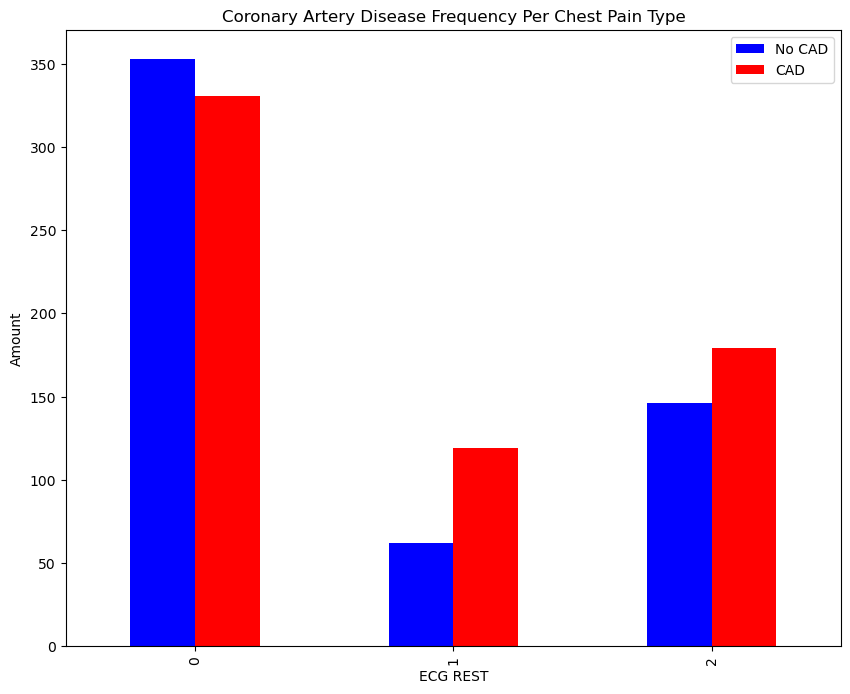

In [42]:
# analyze ECG at rest data
pd.crosstab(heart_data['resting ecg'],heart_data.target).plot(kind = 'bar',
                                        figsize = (10,8),
                                        color = ['blue','red'])
                                        
                                        

plt.title("Coronary Artery Disease Frequency Per Chest Pain Type");
plt.xlabel("ECG REST")
plt.ylabel("Amount")
plt.legend(["No CAD", "CAD"])

In [43]:
# this analysis justifies additional correction
heart_data.loc[heart_data["resting ecg"] == 2.0, "resting ecg"] = 3.0
heart_data.loc[heart_data["resting ecg"] == 1.0, "resting ecg"] = 2.0
heart_data.loc[heart_data["resting ecg"] == 3.0, "resting ecg"] = 1.0

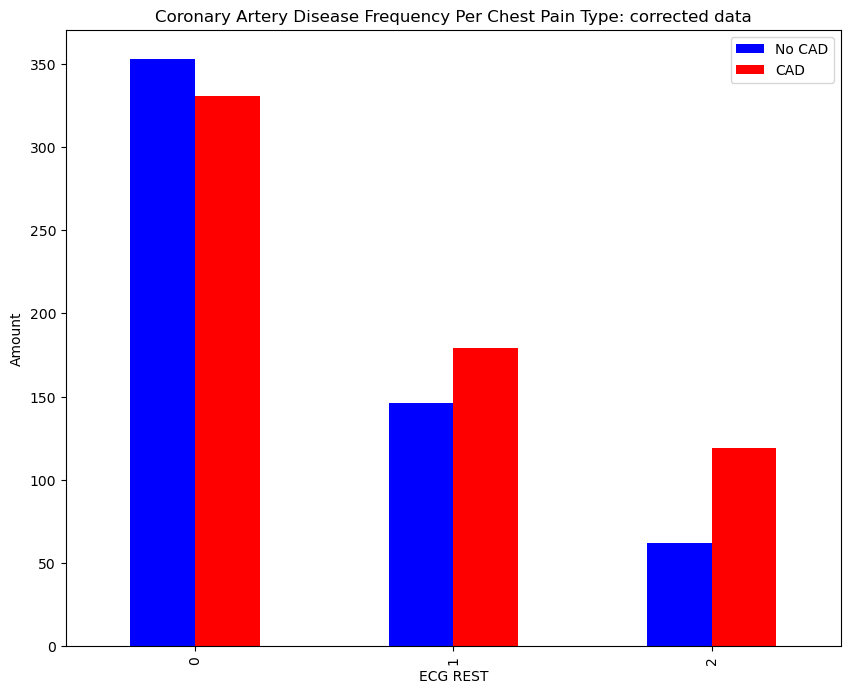

In [44]:
# analyze ECG at rest data
pd.crosstab(heart_data['resting ecg'],heart_data.target).plot(kind = 'bar',
                                        figsize = (10,8),
                                        color = ['blue','red'])
                                        
                                        

plt.title("Coronary Artery Disease Frequency Per Chest Pain Type: corrected data");
plt.xlabel("ECG REST")
plt.ylabel("Amount")
plt.legend(["No CAD", "CAD"])

In [45]:
heart_data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000
mean,53.720,0.764,3.233,132.265,245.907,0.213,0.577,139.733,0.387,0.923,1.624,0.529
std,9.358,0.425,0.935,17.964,52.942,0.410,0.741,25.518,0.487,1.086,0.610,0.499
min,28.000,0.000,1.000,80.000,85.000,0.000,0.000,60.000,0.000,-2.600,0.000,0.000
25%,47.000,1.000,3.000,120.000,214.000,0.000,0.000,121.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,245.907,0.000,0.000,140.500,0.000,0.600,2.000,1.000
75%,60.000,1.000,4.000,140.000,269.750,0.000,1.000,160.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [46]:
heart_data.corr()
# now cholesterol is popsitively corralated with coronary artery disease and cardiologist are happy

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,1.000,0.015,0.149,0.264,0.092,0.179,0.198,-0.369,0.188,0.245,0.238,0.262
sex,0.015,1.000,0.138,-0.003,-0.127,0.111,0.038,-0.182,0.194,0.096,0.128,0.311
chest pain type,0.149,0.138,1.000,0.008,0.078,0.076,0.068,-0.337,0.403,0.224,0.277,0.460
resting bp s,0.264,-0.003,0.008,1.000,0.101,0.087,0.121,-0.100,0.141,0.183,0.095,0.130
cholesterol,0.092,-0.127,0.078,0.101,1.000,0.039,0.036,-0.011,0.075,0.050,0.055,0.098
fasting blood sugar,0.179,0.111,0.076,0.087,0.039,1.000,0.112,-0.119,0.053,0.031,0.146,0.217
resting ecg,0.198,0.038,0.068,0.121,0.036,0.112,1.000,-0.102,0.102,0.101,0.102,0.122
max heart rate,-0.369,-0.182,-0.337,-0.100,-0.011,-0.119,-0.102,1.000,-0.378,-0.184,-0.351,-0.413
exercise angina,0.188,0.194,0.403,0.141,0.075,0.053,0.102,-0.378,1.000,0.371,0.393,0.481
oldpeak,0.245,0.096,0.224,0.183,0.050,0.031,0.101,-0.184,0.371,1.000,0.525,0.398


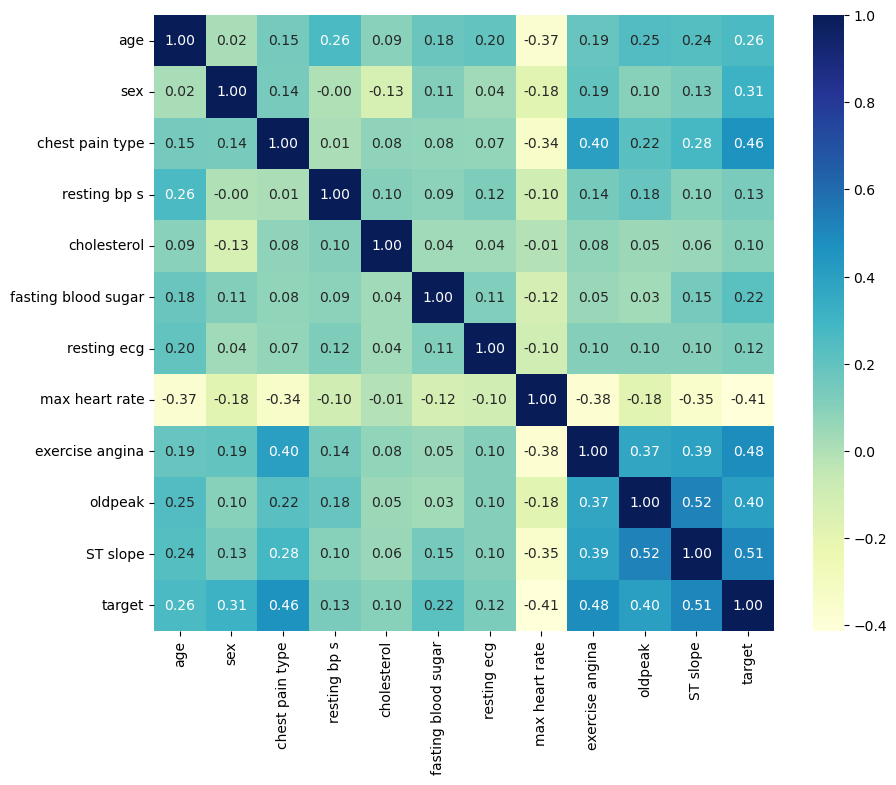

In [47]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(heart_data.corr(),
                annot = True,
                fmt = ".2f",
                cmap = 'YlGnBu')

## TwoLocal 4-qubit feature map for 11 features

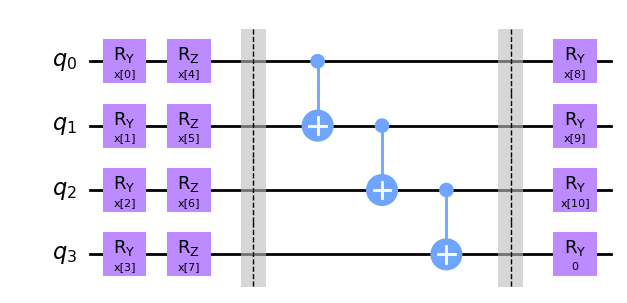

In [13]:
p1 = ParameterVector('x', 11)  
feature_map = QuantumCircuit(4)
for i in range(4):
    feature_map.ry(p1[i],i)
for i in range(4):
    feature_map.rz(p1[i+4],i)
feature_map.barrier()
for i in range(3):
    feature_map.cx(i,i+1)
feature_map.barrier()
for i in range(3):
    feature_map.ry(p1[i+8],i)
feature_map.ry(0,3)
feature_map.draw(output="mpl")

In [14]:
zz_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [15]:
list_feature =  ['age', 'sex', 'chest pain type','resting bp s','cholesterol','fasting blood sugar',
                 'resting ecg','max heart rate','exercise angina', 'oldpeak', 'ST slope']       
nb_row = 100
np_score = np.zeros([nb_row, 2], dtype=float)
for i, random_state in enumerate(range(nb_row)):
        output_svc, sample_test, label_test = support_vector_machine(heart_data,
                                                                      list_feature,
                                                                      "linear",
                                                                      random_state)
        np_score[i][0] = output_svc.score(sample_test, label_test)
        

### Finding random state corresponding to mean accuracy value

In [16]:
def compute_accuracy(df, list_feature, kernel, random_state):
        output_svc, sample_test, label_test = support_vector_machine(df,
                                                                     list_feature,
                                                                     kernel,
                                                                     random_state)
        return accuracy_score(label_test, output_svc.predict(sample_test))  

In [18]:
for i, random_state in enumerate(range(nb_row)):            
    np_score[i][0] = compute_accuracy(heart_data,
                                      list_feature,
                                      "linear",
                                      random_state)
    np_score[i][1] = compute_accuracy(heart_data,
                                      list_feature,
                                      zz_kernel.evaluate,
                                      random_state) 
    print(i, np_score[i])

0 [0.84033613 0.82633053]
1 [0.84313725 0.84593838]
2 [0.85434174 0.84593838]
3 [0.81232493 0.82352941]
4 [0.85434174 0.85714286]
5 [0.83193277 0.8487395 ]
6 [0.84313725 0.83473389]
7 [0.81792717 0.80952381]
8 [0.83193277 0.83193277]
9 [0.82072829 0.82072829]
10 [0.81792717 0.82633053]
11 [0.83193277 0.83473389]
12 [0.83193277 0.82633053]
13 [0.83193277 0.83193277]
14 [0.82072829 0.82633053]
15 [0.81512605 0.80672269]
16 [0.82633053 0.82072829]
17 [0.82072829 0.81792717]
18 [0.83753501 0.82633053]
19 [0.80952381 0.79831933]
20 [0.84313725 0.84593838]
21 [0.82352941 0.80392157]
22 [0.84593838 0.83473389]
23 [0.84313725 0.85434174]
24 [0.83473389 0.82072829]
25 [0.85434174 0.82913165]
26 [0.80952381 0.82352941]
27 [0.80952381 0.80392157]
28 [0.84033613 0.82913165]
29 [0.82913165 0.81512605]
30 [0.80672269 0.80392157]
31 [0.80112045 0.79831933]
32 [0.80952381 0.80392157]
33 [0.8487395  0.83473389]
34 [0.82352941 0.81232493]
35 [0.82913165 0.82633053]
36 [0.84313725 0.84313725]
37 [0.82352

In [19]:
columns_values = ['classical','qsvm']
index_values = list(range(nb_row))
acc_df = pd.DataFrame(data = np_score, index = index_values,
                  columns = columns_values)
acc_df.describe()    

,classical,qsvm
count,100.000,100.000
mean,0.829,0.826
std,0.016,0.017
min,0.787,0.782
25%,0.818,0.815
50%,0.832,0.826
75%,0.841,0.835
max,0.866,0.866


In [20]:
# was run
acc_df.to_csv('restecg_ieee_11_acc.csv', index=False)

In [21]:
from scipy.stats import ttest_rel
ttest_rel(acc_df.classical, acc_df.qsvm)

Ttest_relResult(statistic=3.360048532286986, pvalue=0.001107929423643579)

In [22]:
from scipy.stats import linregress
res = linregress(acc_df.classical, acc_df.qsvm)
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.670093


In [23]:
print(res)

LinregressResult(slope=0.8753743134451882, intercept=0.09989627993248307, rvalue=0.8185918306284221, pvalue=2.46178686472962e-25, stderr=0.06204537203967572, intercept_stderr=0.05144484752642233)


In [24]:
dist_array = ( np_score[:,0]-np.mean(np_score[:,0]) )**2\
             + ( np_score[:,1]-np.mean(np_score[:,1]) )**2
random_state = dist_array.argmin()
print("random_state for score nearest to the mean intersection:", random_state)
print("classical score :", np_score[:,0][random_state])
print("     qsvm score :", np_score[:,1][random_state])                

random_state for score nearest to the mean intersection: 35
classical score : 0.8291316526610645
     qsvm score : 0.8263305322128851


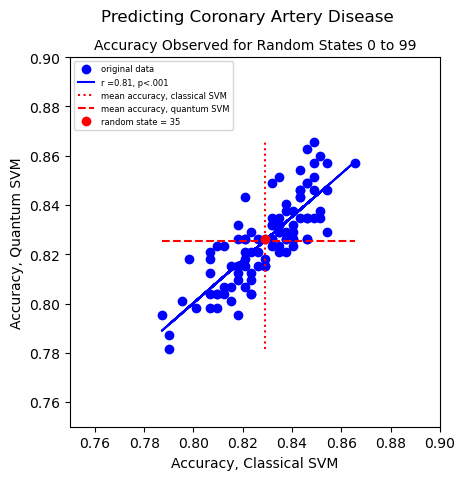

In [25]:
x = acc_df.classical
y = acc_df.qsvm
plt.plot(x, y, 'ob', label='original data')
plt.suptitle("Predicting Coronary Artery Disease" )
plt.title("Accuracy Observed for Random States 0 to 99", fontsize = 10) 
plt.xlabel("Accuracy, Classical SVM")
plt.ylabel("Accuracy, Quantum SVM")
plt.plot(x, res.intercept + res.slope*x, 'b',
         label='r ='+str(res.rvalue)[:4]+", p<.001"  )
plt.vlines( np.mean(x), np.min(y), np.max(y), 'r',
           linestyles='dotted', label = 'mean accuracy, classical SVM')
plt.hlines( np.mean(y), np.min(x), np.max(x), 'r',
           linestyles='dashed', label = 'mean accuracy, quantum SVM')
plt.plot(np_score[:,0][random_state], np_score[:,1][random_state],
         'or', label = #"nearest # to means\
          "random state = " + str(random_state) )
plt.legend(loc=2, prop={'size': 6})
plt.xlim(0.75, 0.90)
plt.ylim(0.75, 0.90)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

random state 35
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       168
           1       0.85      0.83      0.84       189

    accuracy                           0.83       357
   macro avg       0.83      0.83      0.83       357
weighted avg       0.83      0.83      0.83       357



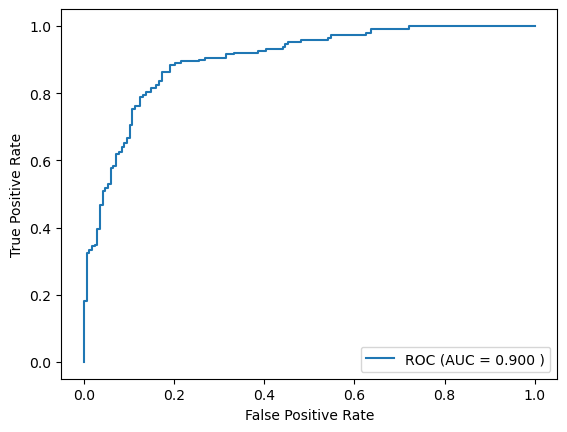

In [26]:
show_metrics(heart_data, list_feature, "linear", random_state)

random state 35
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       168
           1       0.84      0.83      0.84       189

    accuracy                           0.83       357
   macro avg       0.83      0.83      0.83       357
weighted avg       0.83      0.83      0.83       357



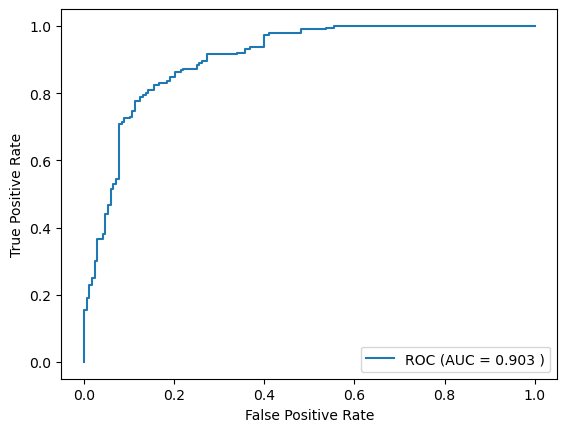

In [27]:
show_metrics(heart_data, list_feature, zz_kernel.evaluate, random_state)

random state 35
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']
{'ROC Classical SVM:': 'linear', 'ROC Quantum SVM:': <bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000001F8732B7610>>}



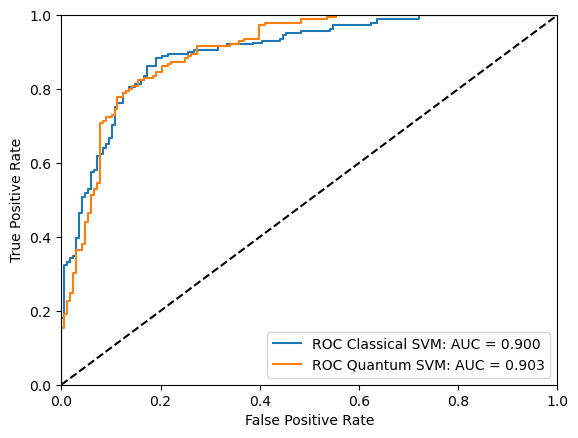

In [28]:
def show_aucs(data, list_feature, kernel_dic, random_state):
    print("random state", random_state)
    print(list_feature)
    print(kernel_dic)
    print()
    
    plt.figure(0).clf()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0,1], [0,1], 'k--')

    for k_name, kernel in kernel_dic.items():
        
        svc_output , sample_test, y_true = support_vector_machine(data, list_feature, kernel,
                                                                  random_state = random_state)
        y_pred = svc_output.predict(sample_test)
        y_score = svc_output.decision_function(sample_test)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr,tpr,
                 label= k_name+" AUC = %0.3f" % auc)
    plt.legend(loc=0)
    plt.show()

kernel_dic = {"ROC Classical SVM:" : "linear", "ROC Quantum SVM:" : zz_kernel.evaluate}
show_aucs(heart_data, list_feature, kernel_dic, random_state)